In [31]:
# from circuit_suite import circuits
# # from backend_suite import backends, large_backends, shuffle_test, routing_test
# #from backend_suite import placement_test


In [32]:
# from backend_suite import backends
# backends["Hatlab-Large-Riswap-Dense"].pass_manager.run(circuits["QFT"].circuit_lambda(4))


## Circuit Transpile Benchmark

In [33]:
# make a plot :)
import matplotlib.pyplot as plt


def benchmark(
    backends,
    circuit_generator,
    q_range=None,
    continuously_save=False,
    overwrite=False,
    best_of=3,
):
    # override qrange if provided
    if q_range is None:
        q_range = circuit_generator.q_range

    # check if data dicts are empty
    for backend in backends:
        if not circuit_generator.label in backend.data.keys():
            backend.data[circuit_generator.label] = {}
            backend.data[circuit_generator.label]["duration"] = {}
            backend.data[circuit_generator.label]["preswap_gate_count"] = {}
            backend.data[circuit_generator.label]["gate_count"] = {}
            backend.data[circuit_generator.label]["preswap_gate_count_crit"] = {}
            backend.data[circuit_generator.label]["layout_score"] = {}
            backend.data[circuit_generator.label]["edge_frequency"] = {}

    # outer loop over circuit since this may take long time to generate
    for q in q_range:
        # create new variable sized lambda circuit

        # wait to build circuit (may be costly), if we end up not needing it for any backend
        qc = None
        if overwrite:
            qc = circuit_generator.circuit_lambda(q)

        for backend in backends:

            # condition to skip
            if not overwrite:
                # convert to int because if loaded from json key will be a string
                if q in [
                    int(k)
                    for k in backend.data[circuit_generator.label][
                        "preswap_gate_count"
                    ].keys()
                ]:
                    continue

            # resolve wait
            if qc is None:
                qc = circuit_generator.circuit_lambda(q)

            # logging.info(f"Transpiler qc{q} for {backend.label}")
            print(f"Transpiler qc{q} for {backend.label}")
            backend.pass_manager.run(qc)

            # save data to dict
            # might be empty if not decomposing swaps
            if (
                "duration_longest_path_length"
                in backend.pass_manager.property_set.keys()
            ):
                duration = backend.pass_manager.property_set[
                    "duration_longest_path_length"
                ]
                backend.data[circuit_generator.label]["duration"][str(q)] = float(
                    duration
                )

            gate_count = backend.pass_manager.property_set["preswap_count_ops"]
            backend.data[circuit_generator.label]["preswap_gate_count"][
                str(q)
            ] = gate_count

            gate_count_critical_path = backend.pass_manager.property_set[
                "preswap_count_ops_longest_path"
            ]
            backend.data[circuit_generator.label]["preswap_gate_count_crit"][
                str(q)
            ] = gate_count_critical_path

            gate_count_post_decomp = backend.pass_manager.property_set["count_ops"]
            backend.data[circuit_generator.label]["gate_count"][
                str(q)
            ] = gate_count_post_decomp

            layout_score = backend.pass_manager.property_set["layout_score"]
            backend.data[circuit_generator.label]["layout_score"][str(q)] = float(
                layout_score
            )

            frequency_list = backend.pass_manager.property_set["edge_frequency"]
            backend.data[circuit_generator.label]["edge_frequency"][
                str(q)
            ] = frequency_list

            # for long tests, may want to save more regularly in case exit early
            if continuously_save:
                backend.save_json()

    for backend in backends:
        # save dict to json
        backend.save_json()


In [34]:
# !pip install SciencePlots
# import matplotlib.pyplot as plt
# plt.style.reload_library()
# plt.style.use(['science','no-latex'])

In [173]:
def plot_wrap(backends, circuit_label_list, motivation=False):
    # fig, axs = plt.subplots(len(circuit_label_list),4, figsize=(24,24))
    height = 5
    if motivation:
        height = 2.5
    fig = plt.figure(constrained_layout=True, figsize=(7.16,height))
    plt.style.use(['science'])
    SMALL_SIZE = 4
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 12
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE+4)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE+2)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE+2)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE+2)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE+4)  # fontsize of the figure title
    plt.rc('lines', markersize=2.5, linewidth=1)

    if motivation:
        nrows= 2
    else:
        nrows=4
    axs = fig.subplots(ncols=len(circuit_label_list), nrows=nrows)
    i = 0
    for circuit_label in circuit_label_list:
        ax = plot(
            backends,
            circuit_label,
            duration=2,
            subfig=axs,
            first=(i==0),
            index=i,
            motivation=motivation
            # last=(i + 1 == len(circuit_label_list)),
        )
        i += 1
        circuit_label = circuit_label.replace("_", " ")
        ax.set_xlabel(f"{circuit_label}", y=0)
    # for ax, row in zip(ax[:,0], subfigs):
    #     ax.set_ylabel(row, rotation=0, size='large')
    fig.align_ylabels(axs)
    # fig.tight_layout()
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5,-.01), markerscale=2)
    #savefig
    filename = f"images/data1"
    import os
    i = 0
    while os.path.exists('{}{:d}.pdf'.format(filename, i)):
        i += 1
    fig.savefig('{}{:d}.pdf'.format(filename, i), format="pdf", facecolor='white')

In [163]:
def plot(backends, circuit_label, duration=0, subfig=None, first=False, index=0, motivation=False):
    def mark(backend_label):
        if "Modular" in backend_label:
            return "*"
        if "Google" in backend_label:
            return "o"
        if "IBM" in backend_label or "Heavy" in backend_label:
            return "h"
        if "Square" in backend_label:
            return "s"
        if "Hex-Lattice" in backend_label:
            return "^"
        if "AltDiagonals" in backend_label:
            return "x"
        pass

    if subfig is None:
        if duration == 2:
            fig, (ax2, ax3, ax4, ax1) = plt.subplots(1, 4, figsize=(24, 8))
        else:
            raise NotImplementedError
    else:
        # axs = subfig.subplots(nrows=4, ncols=1)
        ax2 = subfig[0][index]
        ax3= subfig[1][index]
        if not motivation:
            ax4= subfig[2][index]
            ax1= subfig[3][index]
        if motivation:
            ax_list = [ax2,ax3]
        else:
            ax_list = [ax2,ax3,ax4,ax1]
        for ax in ax_list:
            # ax.xaxis.set_major_locator(plt.MaxNLocator(3))
            ax.yaxis.set_major_locator(plt.MaxNLocator(3))
            ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    # elif duration==1:
    #     fig, (ax1) = plt.subplots(1,1, figsize=(12,8))
    # else:
    #     fig, (ax2, ax3) = plt.subplots(1,2, figsize=(24,8))
    for backend in backends:
        if circuit_label in backend.data.keys():
            if 1 or duration == 0:
                # total swap gates
                x = backend.data[circuit_label]["preswap_gate_count"].keys()
                x = [int(el) for el in list(x)]
                y = backend.data[circuit_label]["preswap_gate_count"].values()
                x, y = zip(*zip(x, y))
                y = [el["swap"] if "swap" in el.keys() else 0 for el in y]
                x, y = zip(*sorted(zip(x, y)))
                ax2.plot(x, y, marker=mark(backend.label),label=backend.label)
                #ax2.set_ylabel("Total SWAP Count")
                # if last:
                #     ax2.set_xlabel("Num Qubits")
                if not duration == 2:
                    ax2.legend()
                if first:
                    ax2.set_ylabel("Total SWAP Count")# vs Num Qubits")

            if 1 or duration != 1:
                # critical path swap gates
                x = backend.data[circuit_label]["preswap_gate_count_crit"].keys()
                x = [int(el) for el in list(x)]
                y = backend.data[circuit_label]["preswap_gate_count_crit"].values()
                x, y = zip(*zip(x, y))
                y = [el["swap"] if "swap" in el.keys() else 0 for el in y]
                x, y = zip(*sorted(zip(x, y)))
                ax3.plot(x, y, marker=mark(backend.label), label=backend.label)
                #ax3.set_ylabel("Critical Path SWAP Count")
                # if last:
                #     ax3.set_xlabel("Num Qubits")
                if first:
                    ax3.set_ylabel("Critical Path SWAPs")#  vs Num Qubits")
                if not duration == 2:
                    ax3.legend()
            if not motivation:
                # critical path swap gates
                x = backend.data[circuit_label]["gate_count"].keys()
                x = [int(el) for el in list(x)]
                y = backend.data[circuit_label]["gate_count"].values()
                x, y = zip(*zip(x, y))
                twoqgate_list = ["rzx", "riswap", "cx"]
                for twoqgate in twoqgate_list:
                    temp = [el[twoqgate] if twoqgate in el.keys() else 0 for el in y]
                    if temp[-1] != 0:
                        y = temp
                        break
                x, y = zip(*sorted(zip(x, y)))
                ax4.plot(x, y, marker=mark(backend.label), label=backend.label)
                #ax4.set_ylabel("Total 2Q Gate Count")
                # if last:
                #     ax4.set_xlabel("Num Qubits")
                if first:
                    ax4.set_ylabel("Total 2Q Count")#  vs Num Qubits")
                if not duration == 2:
                    ax4.legend()

            # #duration
            if not motivation:
                x = backend.data[circuit_label]["duration"].keys()
                x = [int(el) for el in list(x)]
                y = backend.data[circuit_label]["duration"].values()
                x, y = zip(*sorted(zip(x, y)))
                ax1.plot(x, y, marker=mark(backend.label),label=backend.label)
                #ax1.set_ylabel("Critical Path 2Q Pulse Duration")
                # if last:
                #     ax1.set_xlabel("Num Qubits")
                if first:
                    ax1.set_ylabel("Pulse Duration")#  vs Num Qubits")
    if motivation: return ax3
    return ax1

    # if duration==2:
    # handles, labels = ax1.get_legend_handles_labels()
    # fig.legend(handles, labels)
    # fig.suptitle(circuit_label, fontsize=32)
    # savefig
    # filename = f"images/{circuit_label}"
    # import os
    # i = 0
    # while os.path.exists('{}{:d}.png'.format(filename, i)):
    #     i += 1
    # fig.savefig('{}{:d}.png'.format(filename, i), facecolor='white')


# plot(placement_test, circuit_gen.label, parameter="duration")
# plot(routing_test, circuit_gen.label, parameter="layout_score")


In [37]:
def edge_histogram(backends, circuit_label):
    from matplotlib import pyplot as plt

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for backend in backends:
        if circuit_label in backend.data.keys():
            # for now only make histogram for largest data point available
            max_key = max(
                [int(el) for el in backend.data[circuit_label]["edge_frequency"].keys()]
            )
            frequency_list = backend.data[circuit_label]["edge_frequency"][str(max_key)]

            # sort dictionary
            frequency_list = dict(
                sorted(frequency_list.items(), key=lambda item: item[1], reverse=True)
            )

            ax.scatter(
                range(len(frequency_list.keys())),
                frequency_list.values(),
                label=backend.label,
            )
            for i, key in enumerate(frequency_list.keys()):
                ax.annotate(key, (i, frequency_list[key]))
                if i >= 3:
                    break

    ax.set_ylabel("Edge Frequency")
    ax.set_xlabel("Edge")
    ax.set_title(f"{circuit_label} {max_key}")
    ax.legend()


In [38]:
# from backend_suite_v2 import decomp_backends
# from circuit_suite import circuits
# circuit_gen = circuits["QAOA_Vanilla"]
# benchmark(backends=decomp_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
# plot(decomp_backends, circuit_gen.label, duration=1)
# #edge_histogram(decomp_backends, circuit_gen.label)
# #circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


In [39]:
# from backend_suite_v2 import modular_backends
# from circuit_suite import circuits
# circuit_gen = circuits["Quantum_Volume"]
# benchmark(backends=modular_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
# plot(modular_backends, circuit_gen.label, duration=1)
# #edge_histogram(decomp_backends, circuit_gen.label)
# #circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


In [78]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits

for circuit_gen in circuits.values():
    benchmark(
        backends=motivation_backends,
        circuit_generator=circuit_gen,
        continuously_save=True,
        overwrite=False,
    )

# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


Transpiler qc80 for Heavy-Hex
Transpiler qc80 for Square-Lattice
Transpiler qc80 for Hex-Lattice
Transpiler qc80 for Lattice+AltDiagonals
Transpiler qc8 for Heavy-Hex
Transpiler qc8 for Square-Lattice
Transpiler qc8 for Hex-Lattice
Transpiler qc8 for Lattice+AltDiagonals
Transpiler qc24 for Heavy-Hex
Transpiler qc24 for Square-Lattice
Transpiler qc24 for Hex-Lattice
Transpiler qc24 for Lattice+AltDiagonals
Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc48 for Heavy-Hex
Transpiler qc48 for Square-Lattice
Transpiler qc48 for Hex-Lattice
Transpiler qc48 for Lattice+AltDiagonals
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice


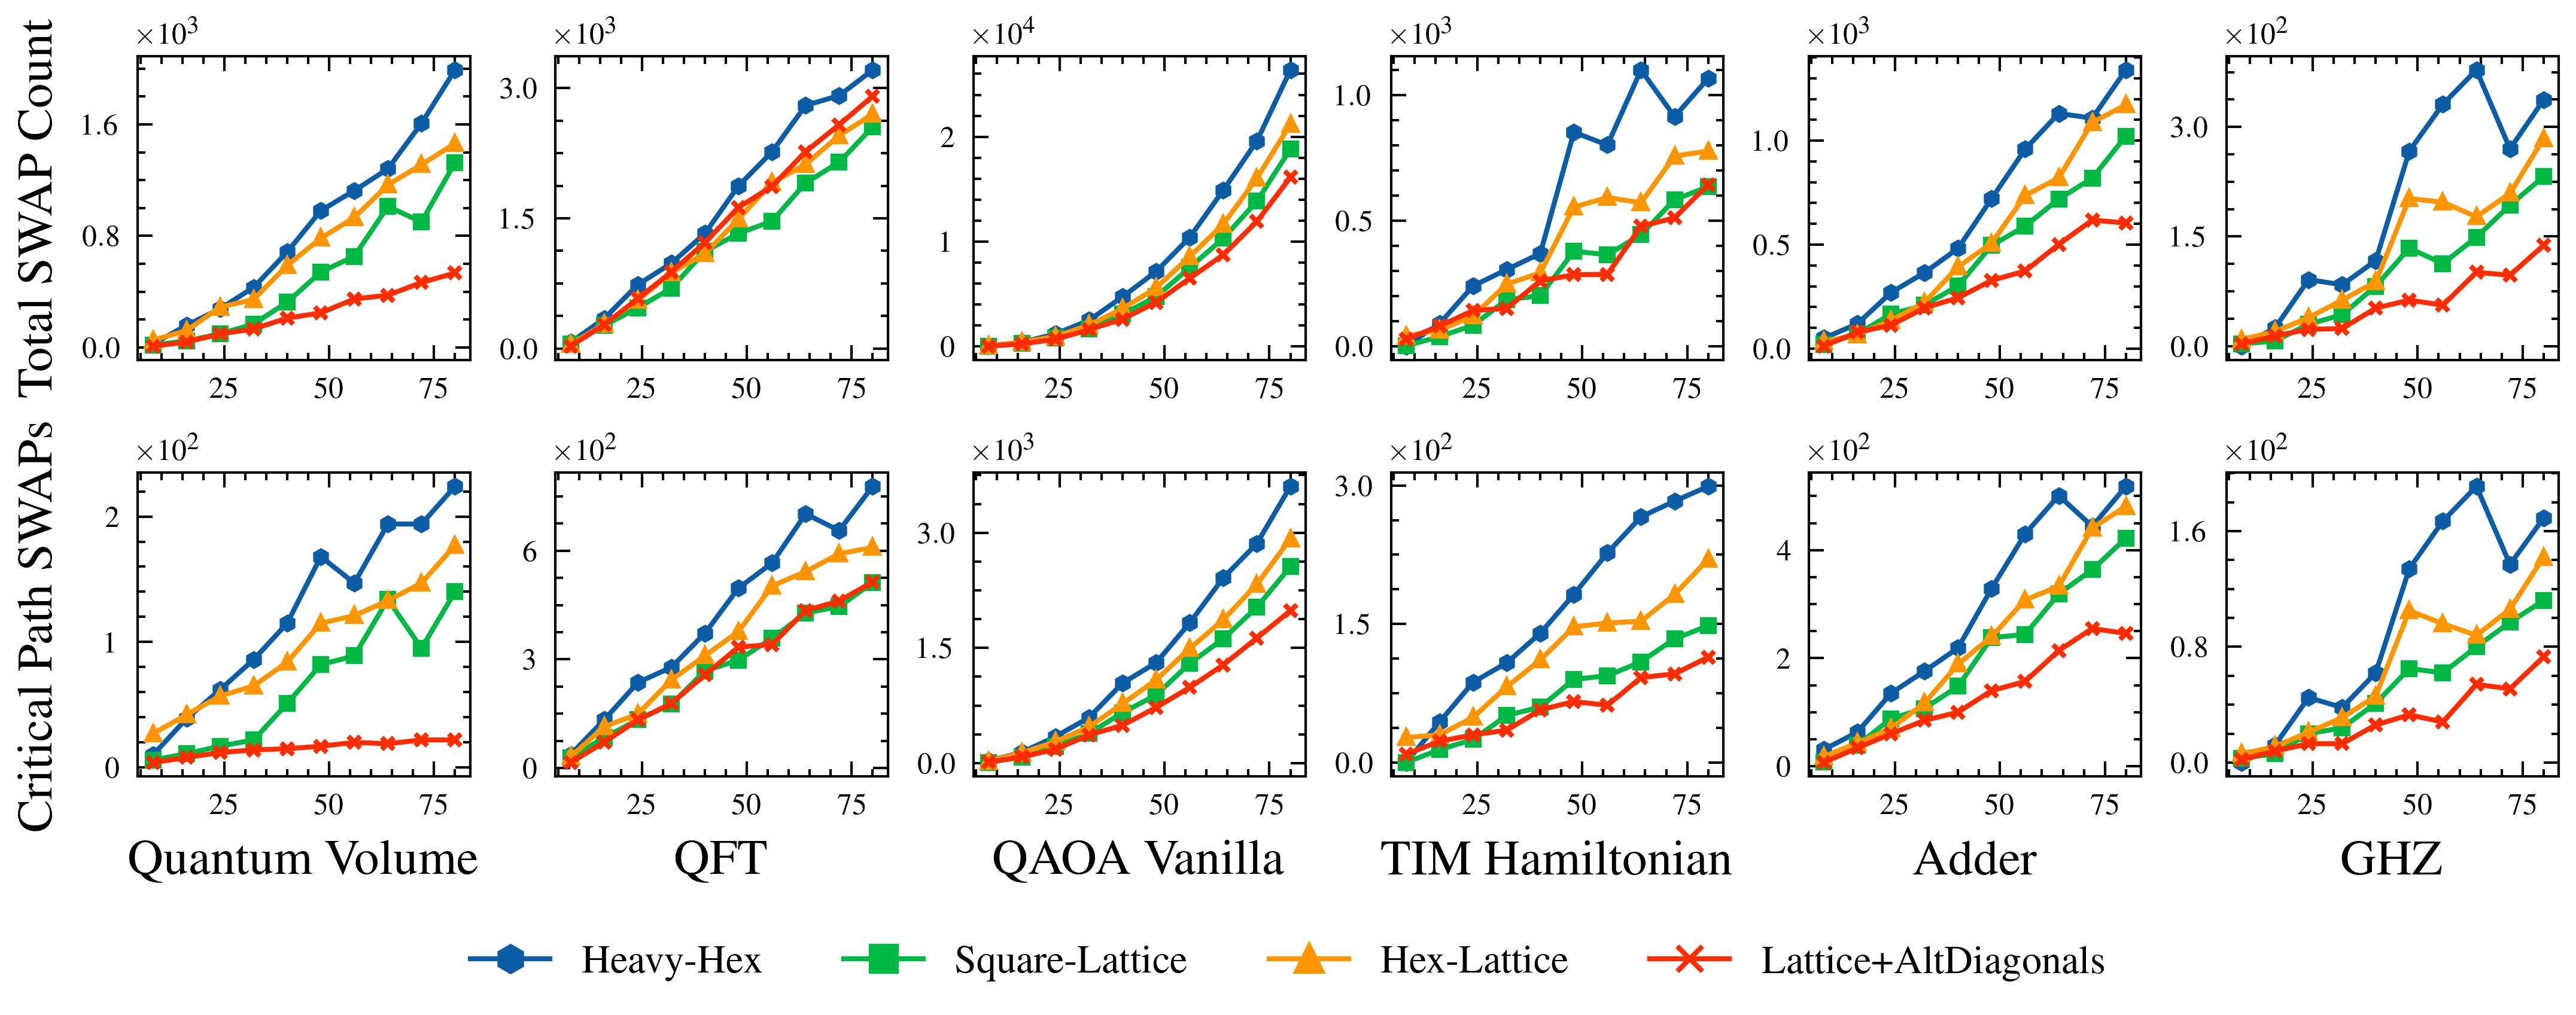

In [174]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits
plot_wrap(motivation_backends, circuits.keys(), motivation=True)

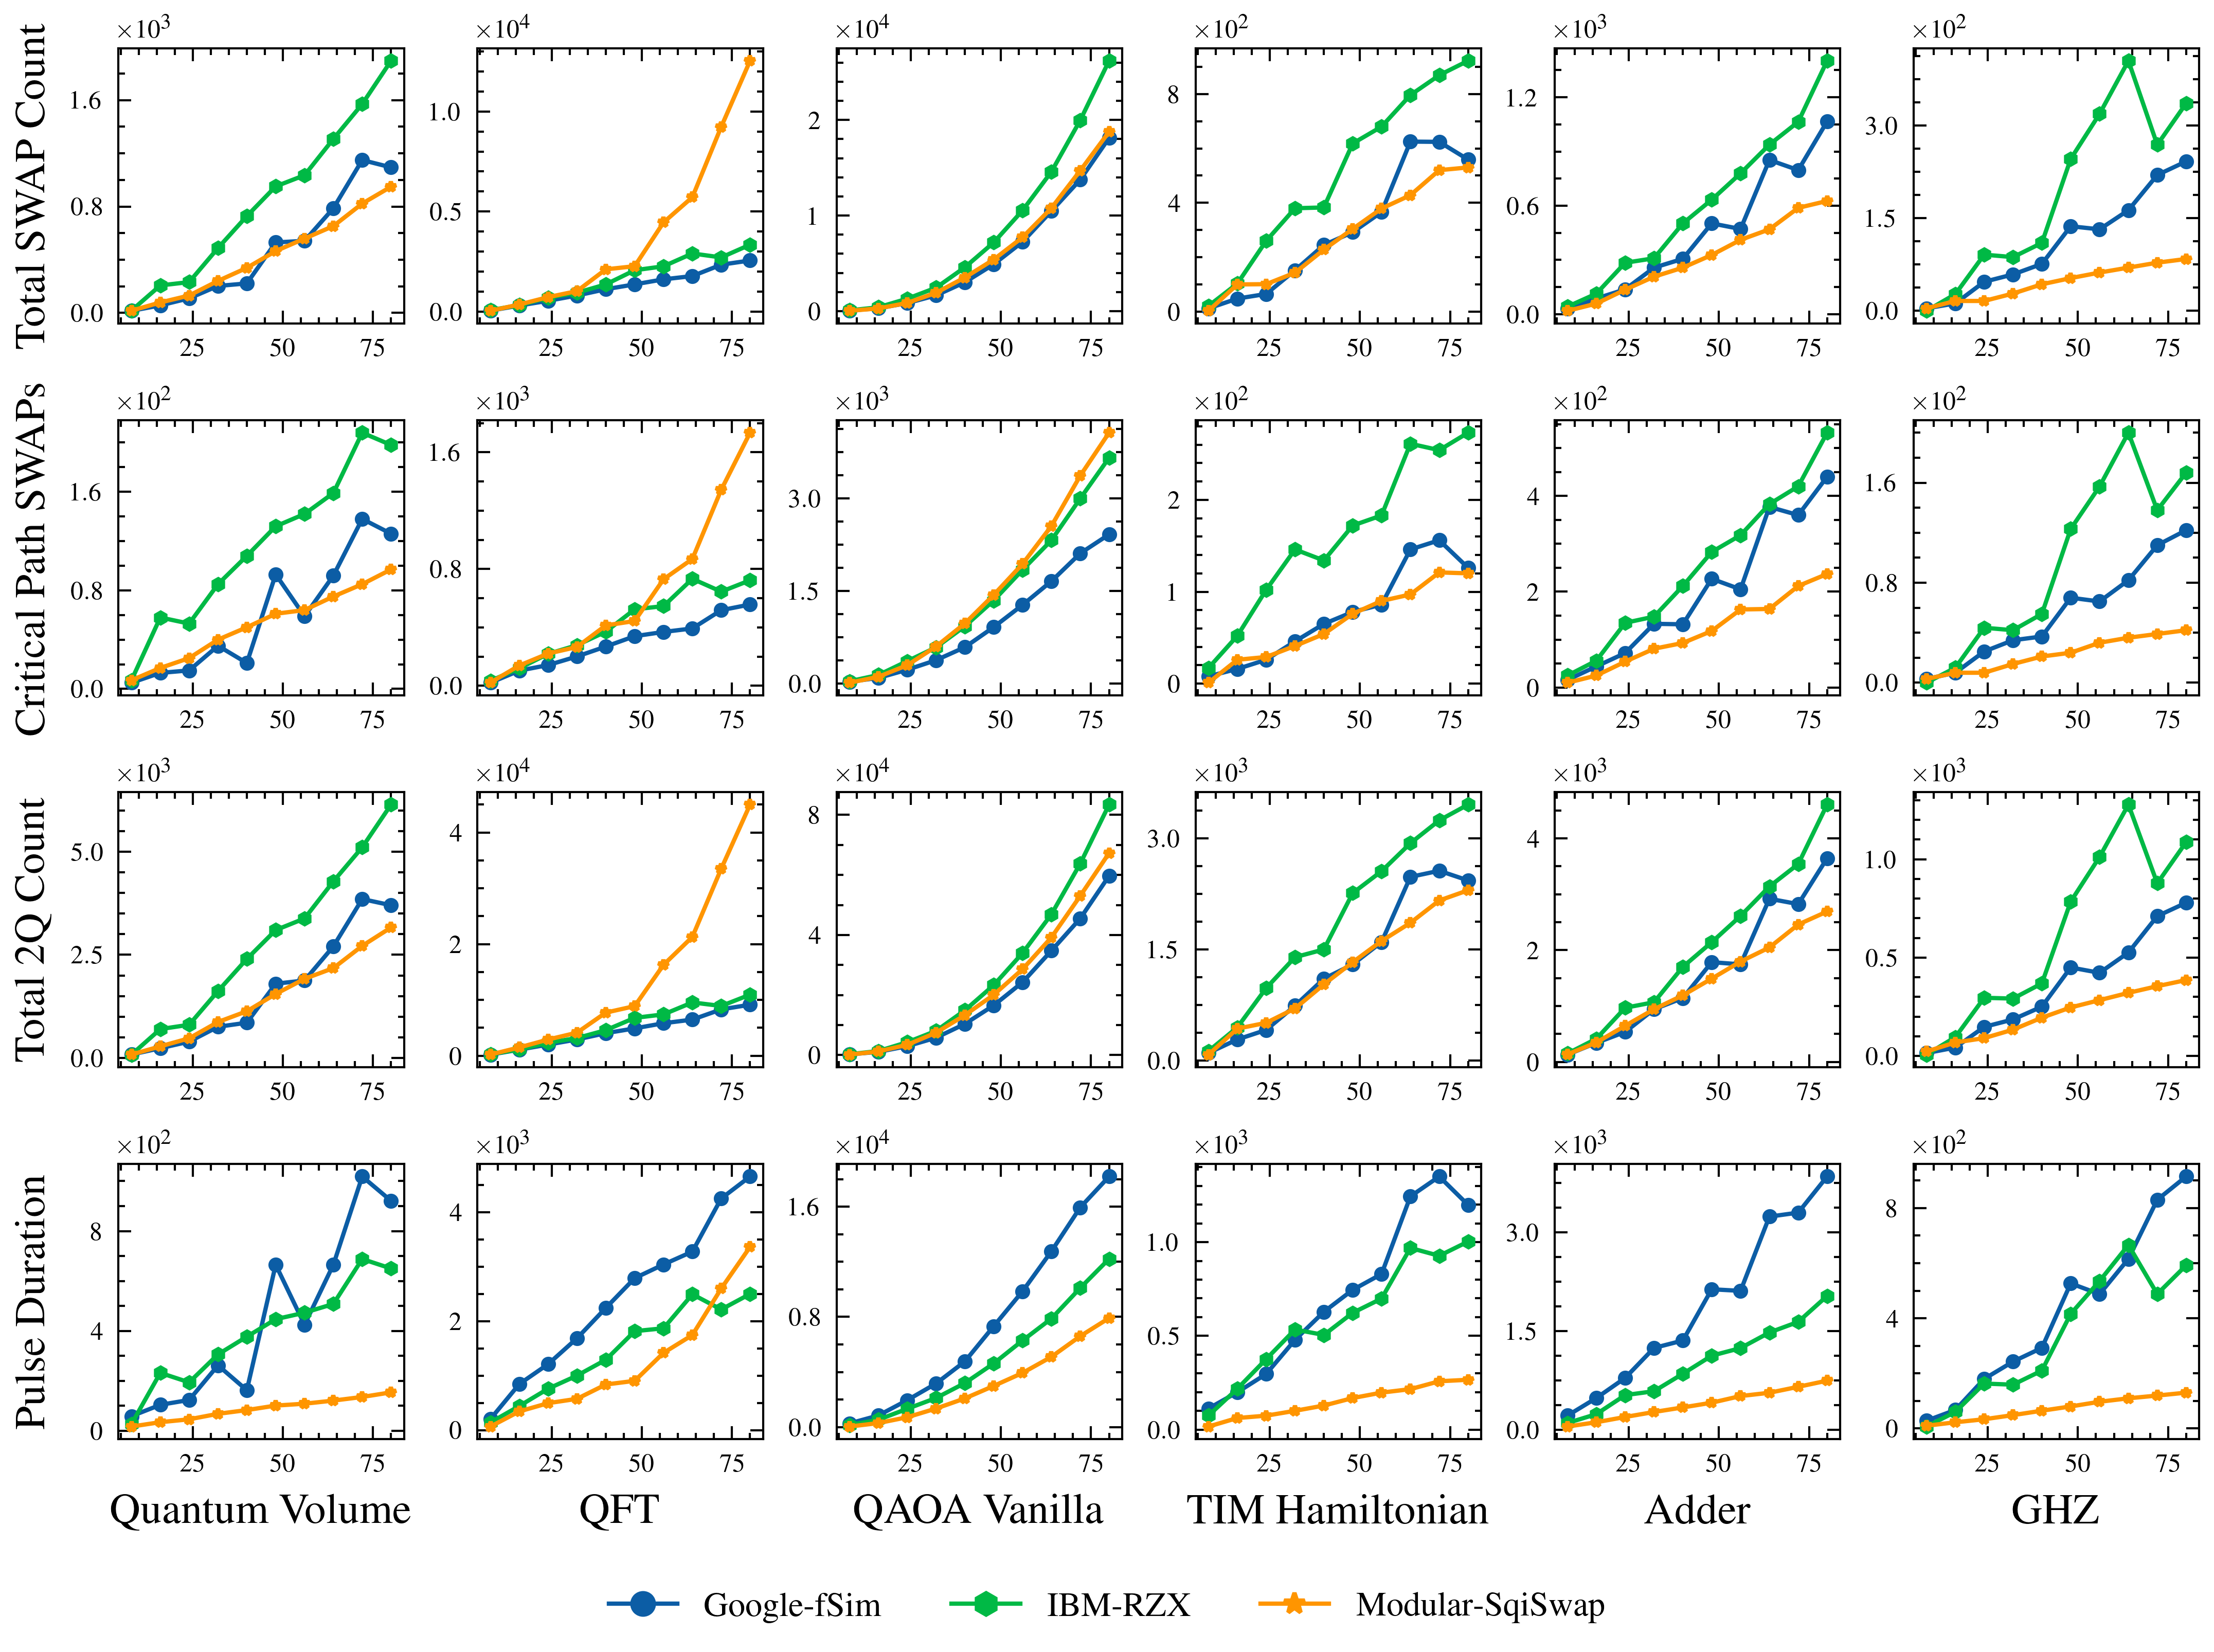

In [175]:
from backend_suite_v2 import industry_backends
from circuit_suite import circuits
plot_wrap(industry_backends, circuits.keys())

/home/evm9/transpilation_EM/venv/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:55: UserWarning: Only know how to decompose properly for supercontrolled basis gate. This gate is ~Ud(0.3926990816987239, 0.3926990816987239, 0.0)
  self.decomposer = TwoQubitBasisDecomposer(kak_basis_gate)


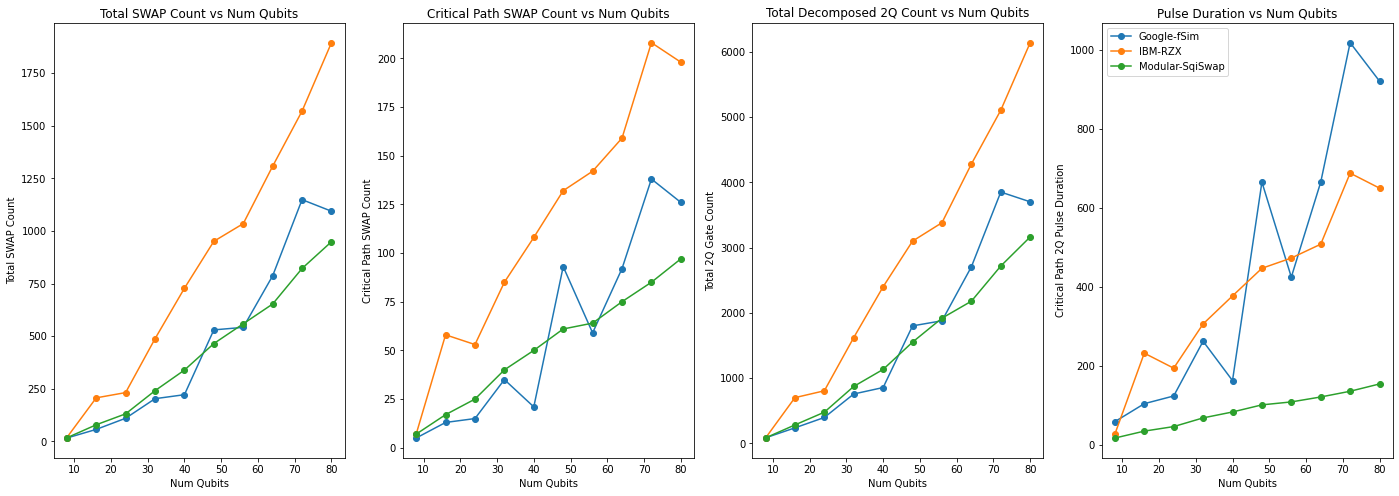

In [5]:
from backend_suite_v2 import industry_backends
from circuit_suite import circuits

circuit_gen = circuits["Quantum_Volume"]
benchmark(
    backends=industry_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(industry_backends, circuit_gen.label, duration=2)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


Transpiler qc8 for Google-fSim
Transpiler qc8 for IBM-RZX
Transpiler qc8 for Modular-SqiSwap
Transpiler qc16 for Google-fSim
Transpiler qc16 for IBM-RZX
Transpiler qc16 for Modular-SqiSwap
Transpiler qc24 for Google-fSim
Transpiler qc24 for IBM-RZX
Transpiler qc24 for Modular-SqiSwap
Transpiler qc32 for Google-fSim
Transpiler qc32 for IBM-RZX
Transpiler qc32 for Modular-SqiSwap
Transpiler qc40 for Google-fSim
Transpiler qc40 for IBM-RZX
Transpiler qc40 for Modular-SqiSwap
Transpiler qc48 for Google-fSim
Transpiler qc48 for IBM-RZX
Transpiler qc48 for Modular-SqiSwap
Transpiler qc56 for Google-fSim
Transpiler qc56 for IBM-RZX
Transpiler qc56 for Modular-SqiSwap
Transpiler qc64 for Google-fSim
Transpiler qc64 for IBM-RZX
Transpiler qc64 for Modular-SqiSwap
Transpiler qc72 for Google-fSim
Transpiler qc72 for IBM-RZX
Transpiler qc72 for Modular-SqiSwap
Transpiler qc80 for Google-fSim
Transpiler qc80 for IBM-RZX
Transpiler qc80 for Modular-SqiSwap


<AxesSubplot:title={'center':'Pulse Duration'}, xlabel='Num Qubits'>

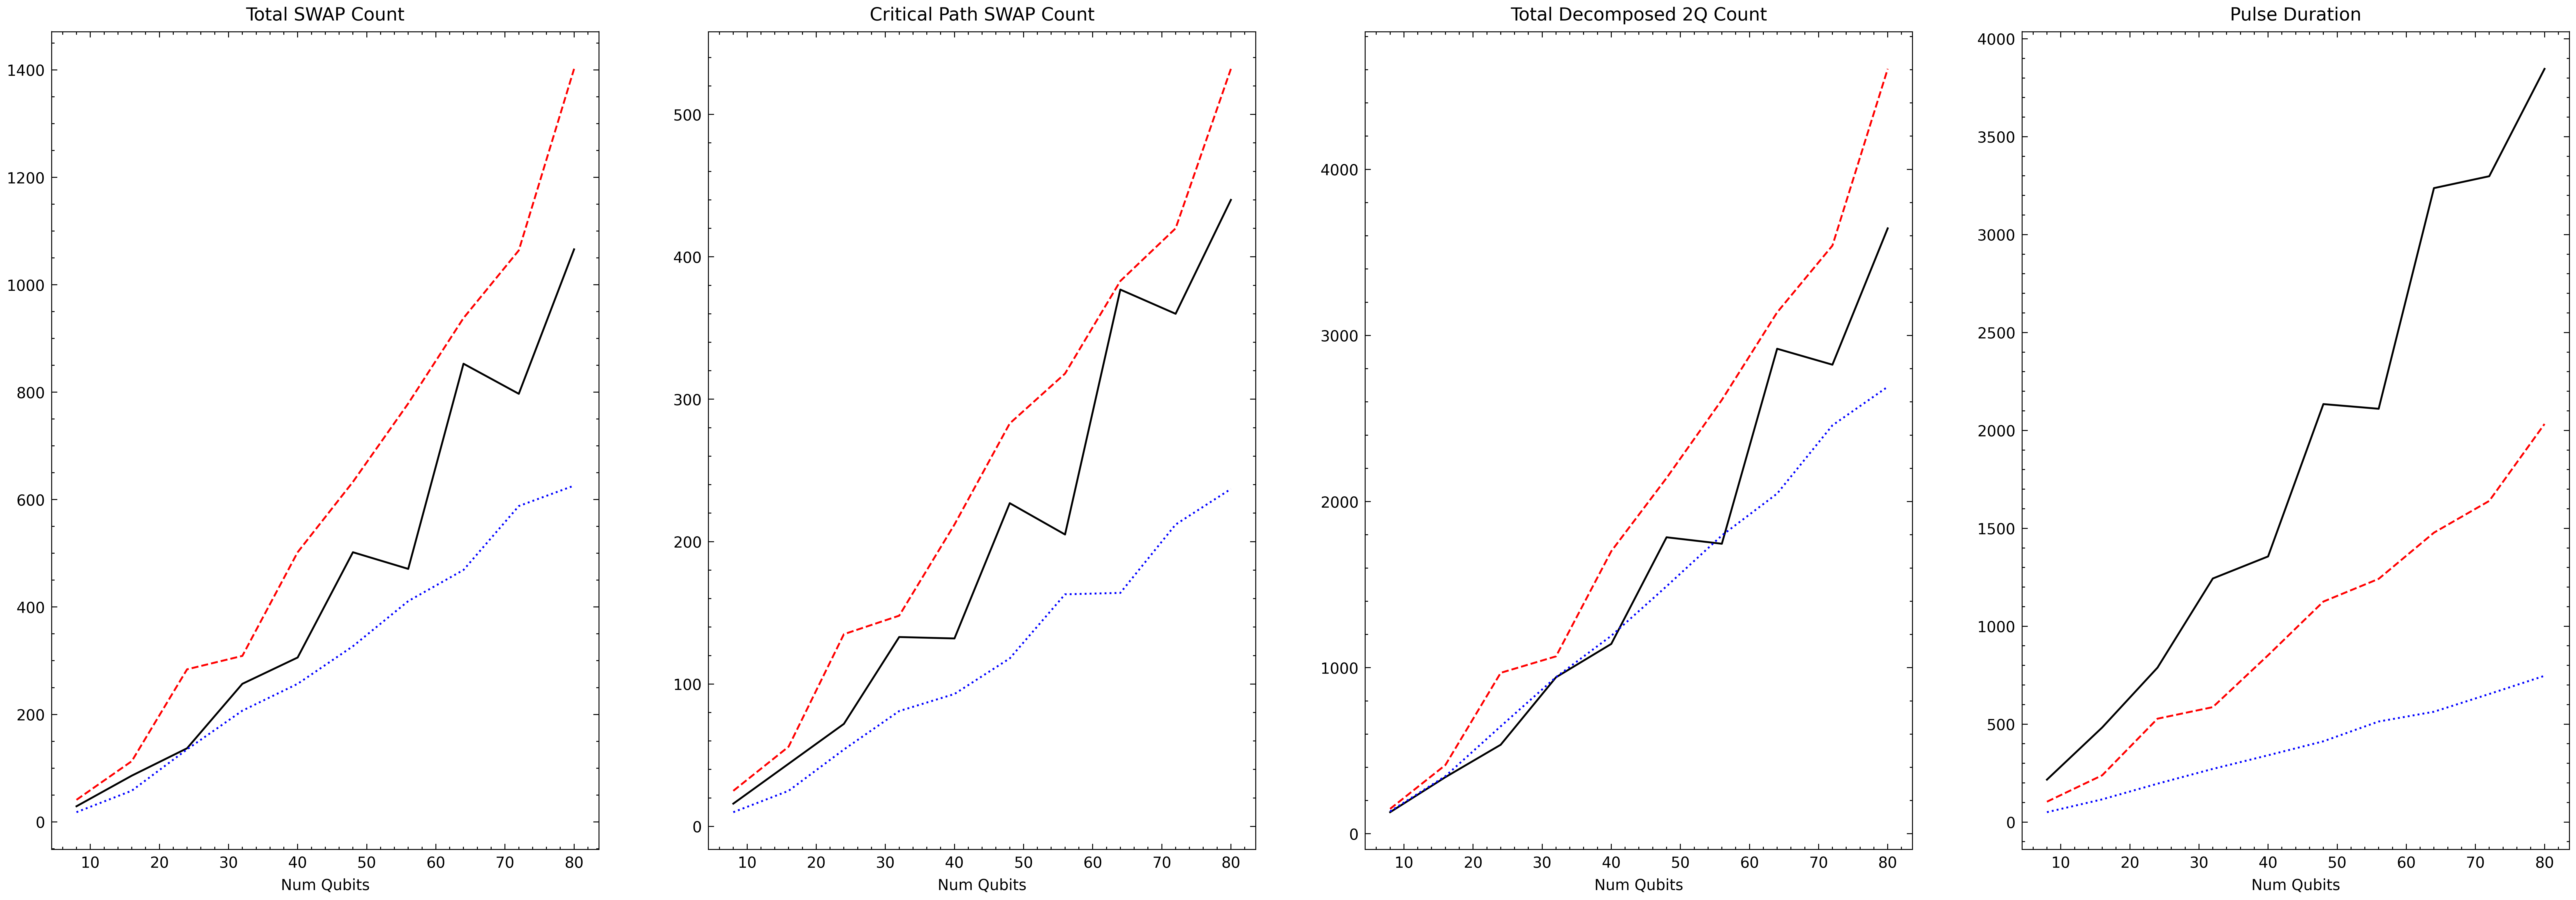

In [56]:
from backend_suite_v2 import industry_backends
from circuit_suite import circuits

circuit_gen = circuits["Adder"]
benchmark(
    backends=industry_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(industry_backends, circuit_gen.label, duration=2)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


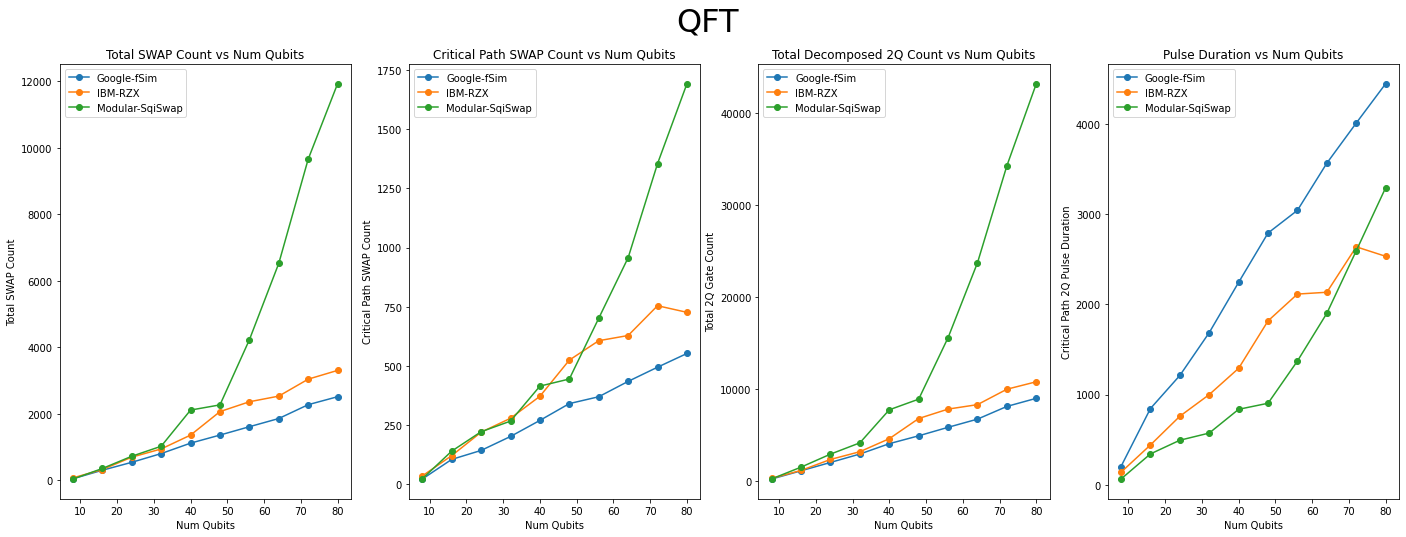

In [9]:
from backend_suite_v2 import industry_backends
from circuit_suite import circuits

circuit_gen = circuits["QFT"]
benchmark(
    backends=industry_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(industry_backends, circuit_gen.label, duration=2)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


Transpiler qc8 for Google-fSim
Transpiler qc8 for IBM-RZX
Transpiler qc8 for Modular-SqiSwap
Transpiler qc16 for Google-fSim
Transpiler qc16 for IBM-RZX
Transpiler qc16 for Modular-SqiSwap
Transpiler qc24 for Google-fSim
Transpiler qc24 for IBM-RZX
Transpiler qc24 for Modular-SqiSwap
Transpiler qc32 for Google-fSim
Transpiler qc32 for IBM-RZX
Transpiler qc32 for Modular-SqiSwap
Transpiler qc40 for Google-fSim
Transpiler qc40 for IBM-RZX
Transpiler qc40 for Modular-SqiSwap
Transpiler qc48 for Google-fSim
Transpiler qc48 for IBM-RZX
Transpiler qc48 for Modular-SqiSwap
Transpiler qc56 for Google-fSim
Transpiler qc56 for IBM-RZX
Transpiler qc56 for Modular-SqiSwap
Transpiler qc64 for Google-fSim
Transpiler qc64 for IBM-RZX
Transpiler qc64 for Modular-SqiSwap
Transpiler qc72 for Google-fSim
Transpiler qc72 for IBM-RZX
Transpiler qc72 for Modular-SqiSwap
Transpiler qc80 for Google-fSim
Transpiler qc80 for IBM-RZX
Transpiler qc80 for Modular-SqiSwap


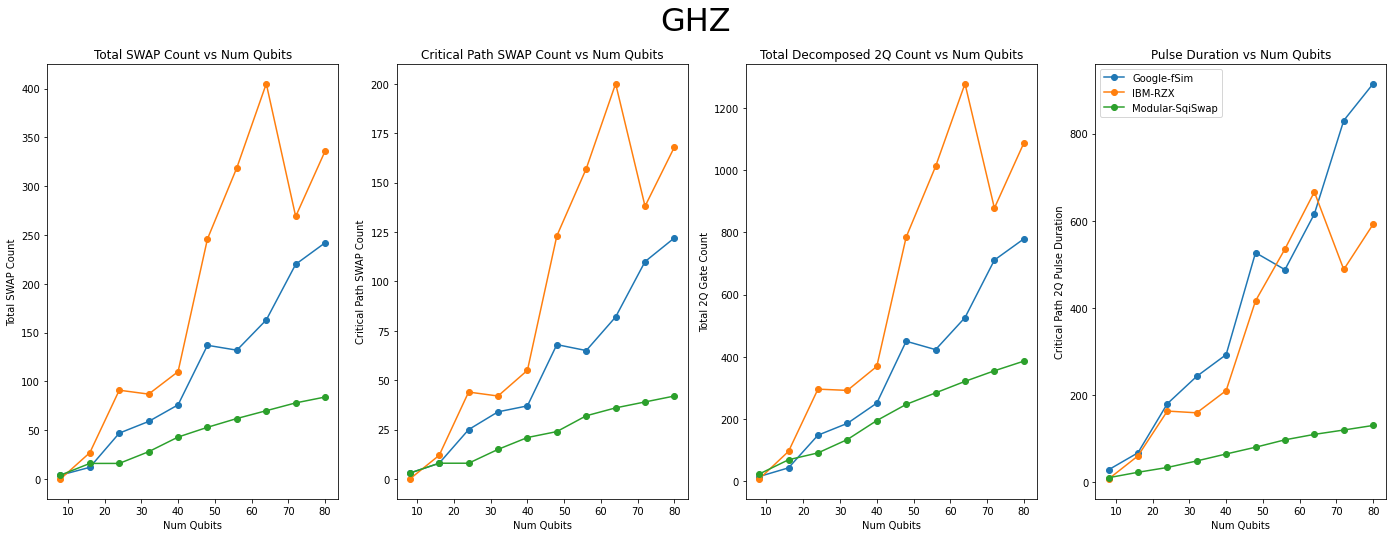

In [12]:
from backend_suite_v2 import industry_backends
from circuit_suite import circuits

circuit_gen = circuits["GHZ"]
benchmark(
    backends=industry_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(industry_backends, circuit_gen.label, duration=2)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


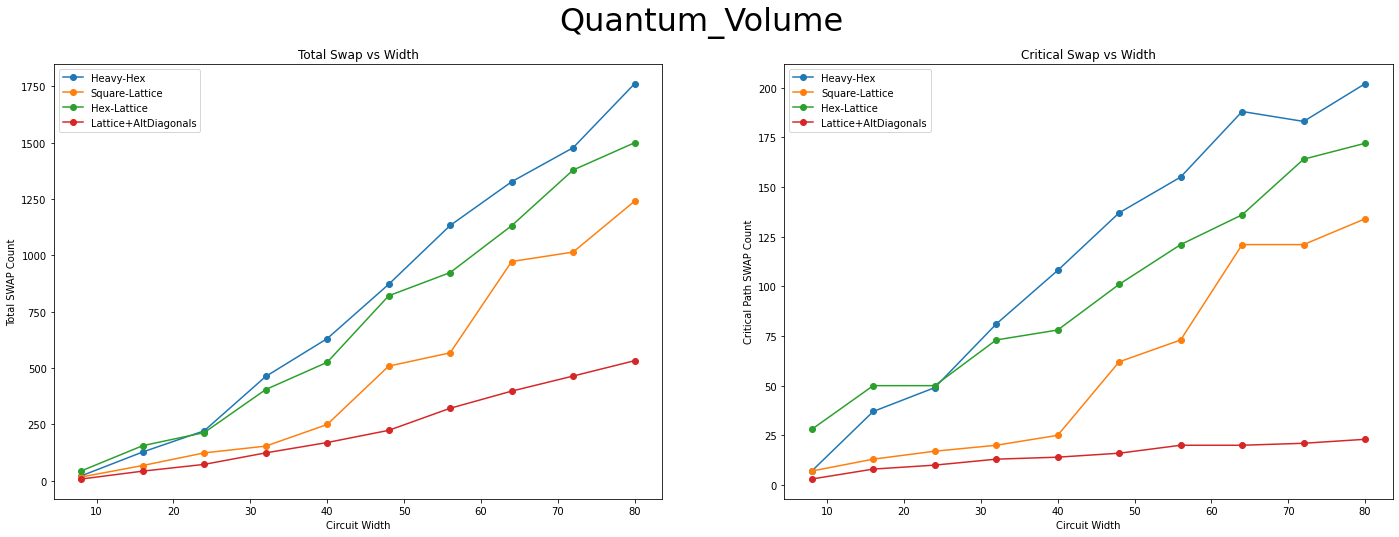

In [10]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits

circuit_gen = circuits["Quantum_Volume"]
benchmark(
    backends=motivation_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(motivation_backends, circuit_gen.label, duration=False)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


In [1]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits

circuit_gen = circuits["QAOA_Vanilla"]
benchmark(
    backends=motivation_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(motivation_backends, circuit_gen.label, duration=False)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


/home/evm9/transpilation_EM/venv/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:55: UserWarning: Only know how to decompose properly for supercontrolled basis gate. This gate is ~Ud(0.3926990816987239, 0.3926990816987239, 0.0)
  self.decomposer = TwoQubitBasisDecomposer(kak_basis_gate)


NameError: name 'benchmark' is not defined

In [ ]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits

circuit_gen = circuits["TIM_Hamiltonian"]
benchmark(
    backends=motivation_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(motivation_backends, circuit_gen.label, duration=False)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


In [ ]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits

circuit_gen = circuits["Adder"]
benchmark(
    backends=motivation_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(motivation_backends, circuit_gen.label, duration=False)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


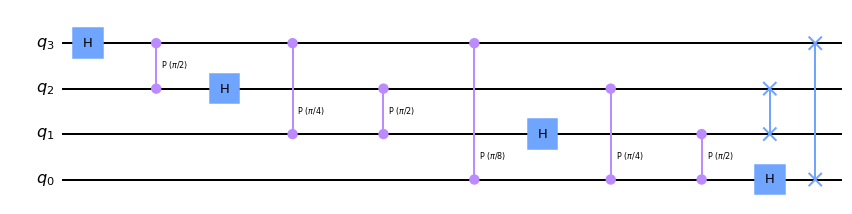

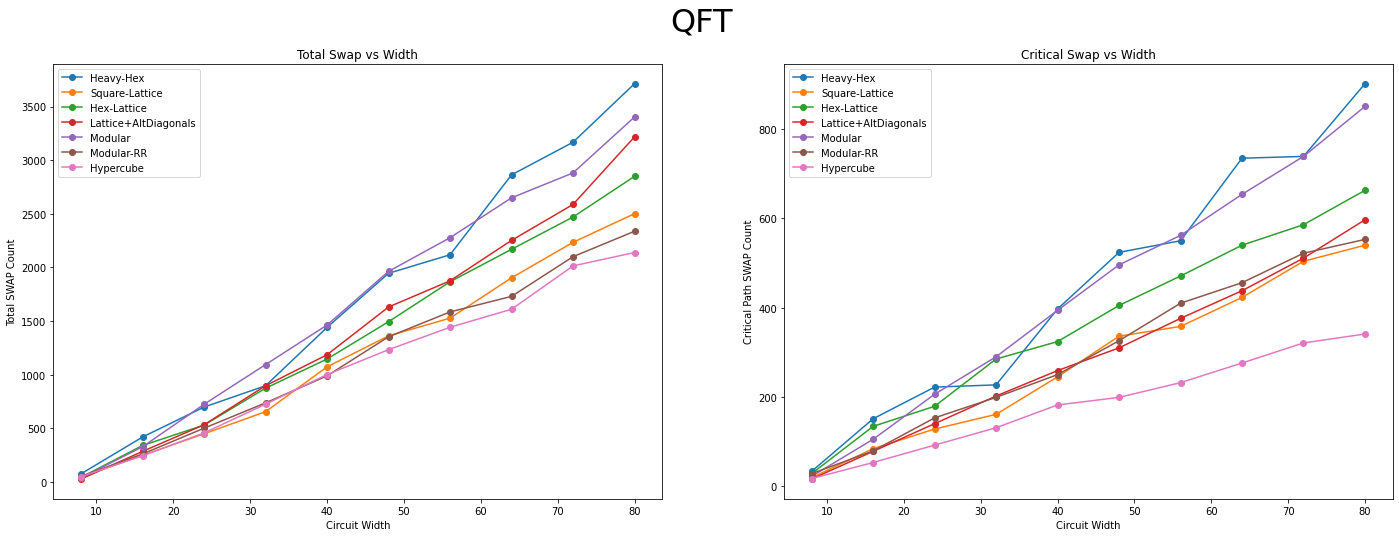

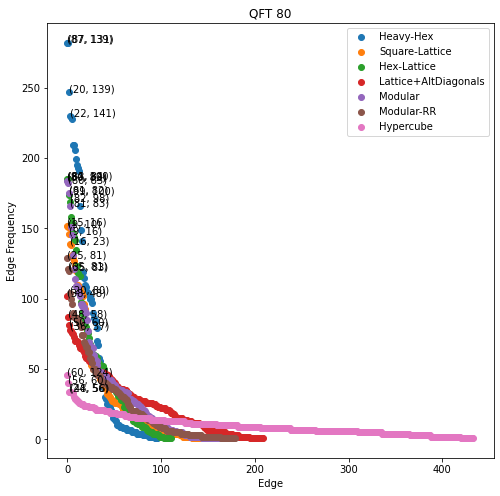

In [15]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

circuit_gen = circuits["QFT"]
benchmark(
    backends=topology_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).decompose().draw(output="mpl", reverse_bits=True)


Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


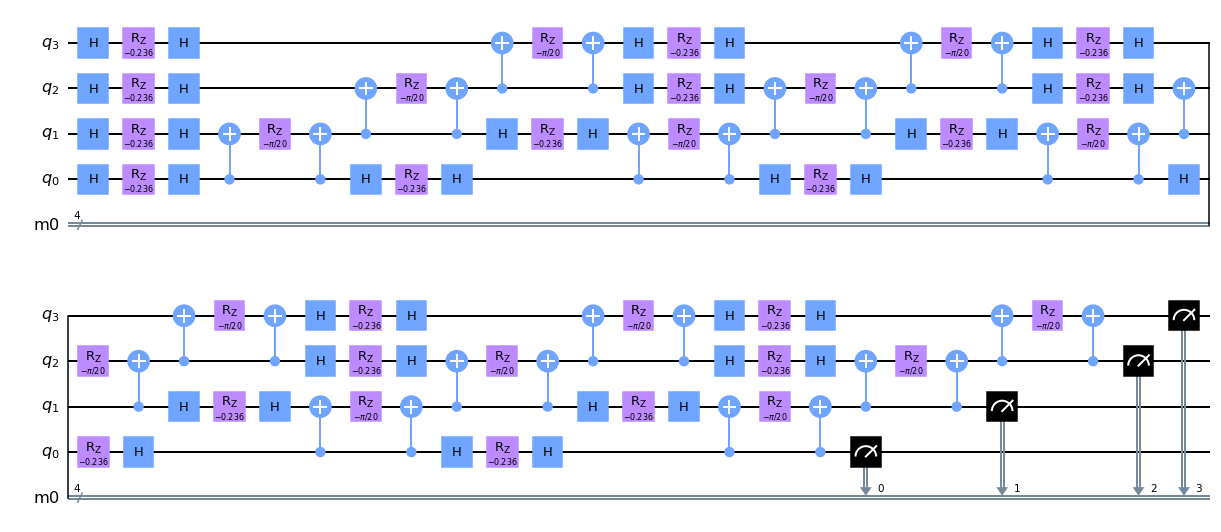

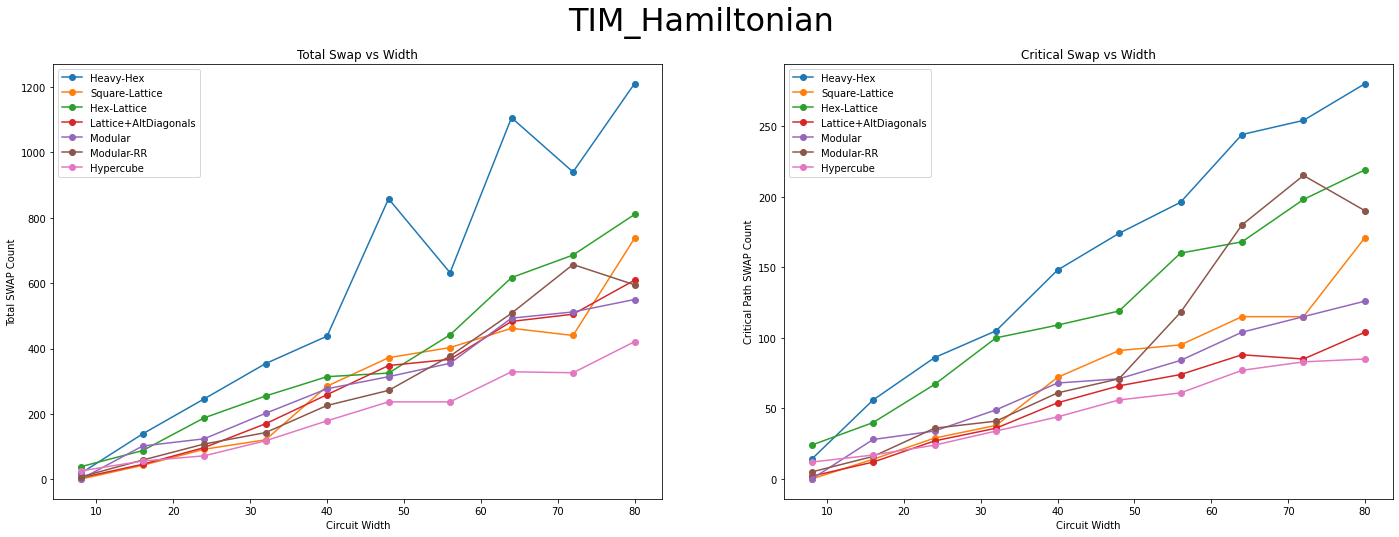

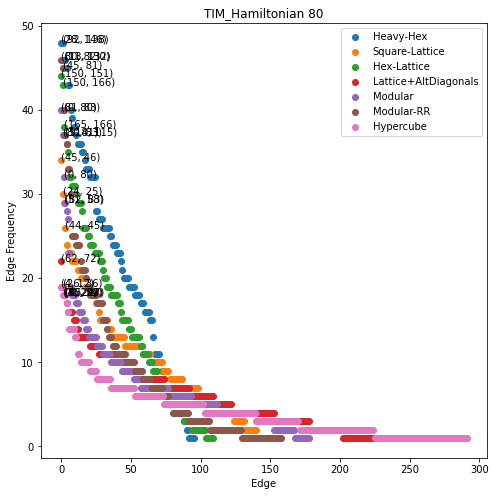

In [16]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

circuit_gen = circuits["TIM_Hamiltonian"]
benchmark(
    backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True
)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output="mpl", reverse_bits=True)


Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


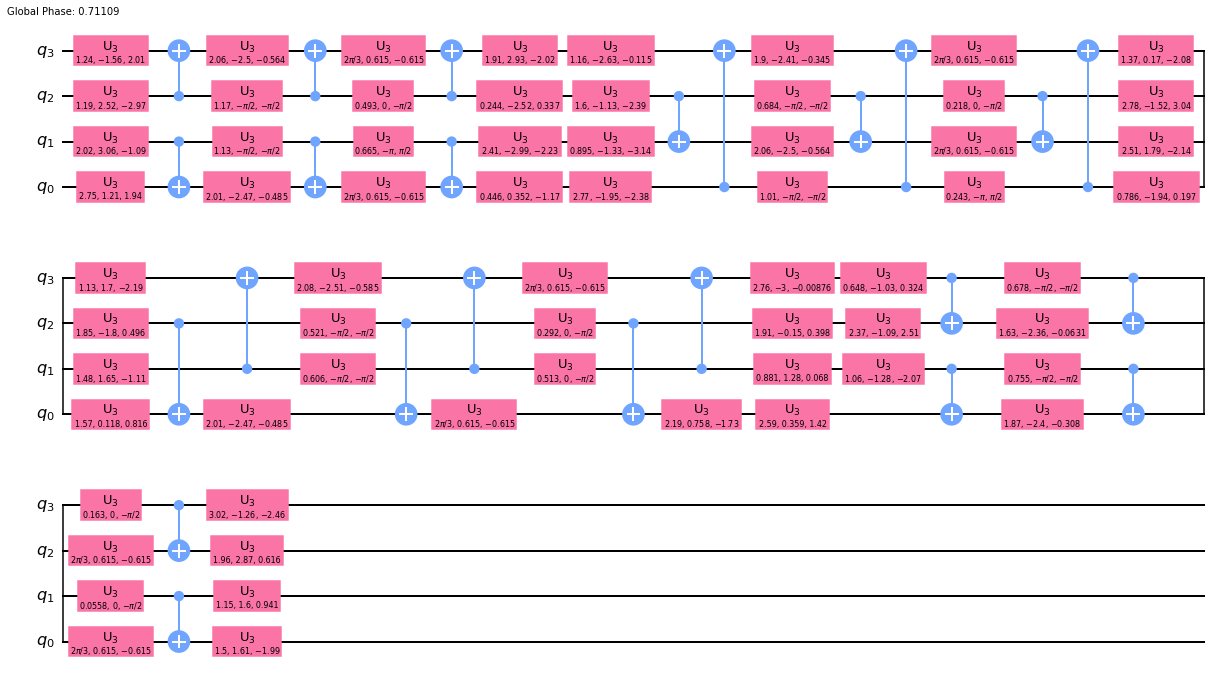

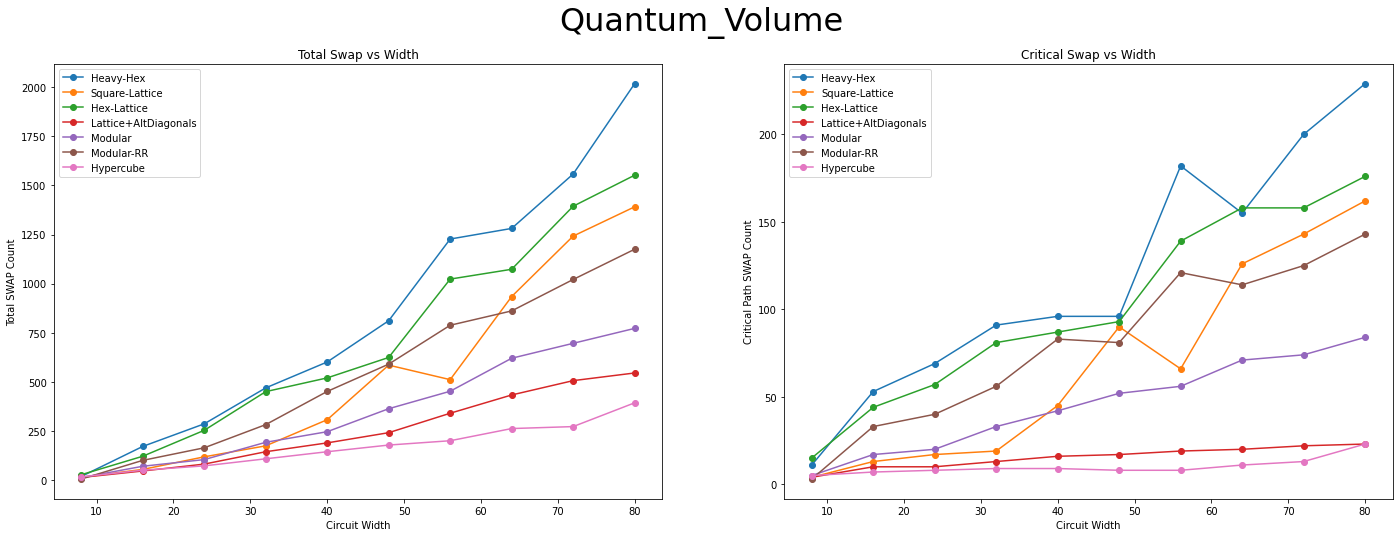

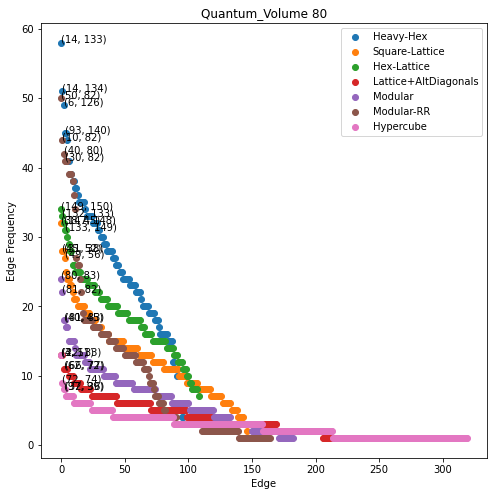

In [17]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

circuit_gen = circuits["Quantum_Volume"]
benchmark(
    backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True
)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).decompose().decompose().draw(
    output="mpl", reverse_bits=True
)


Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


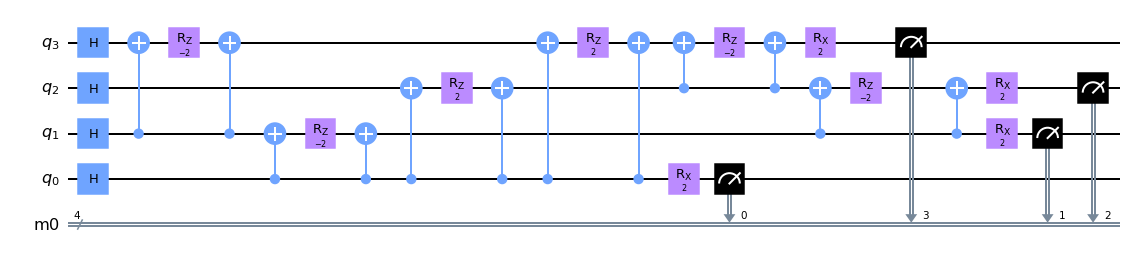

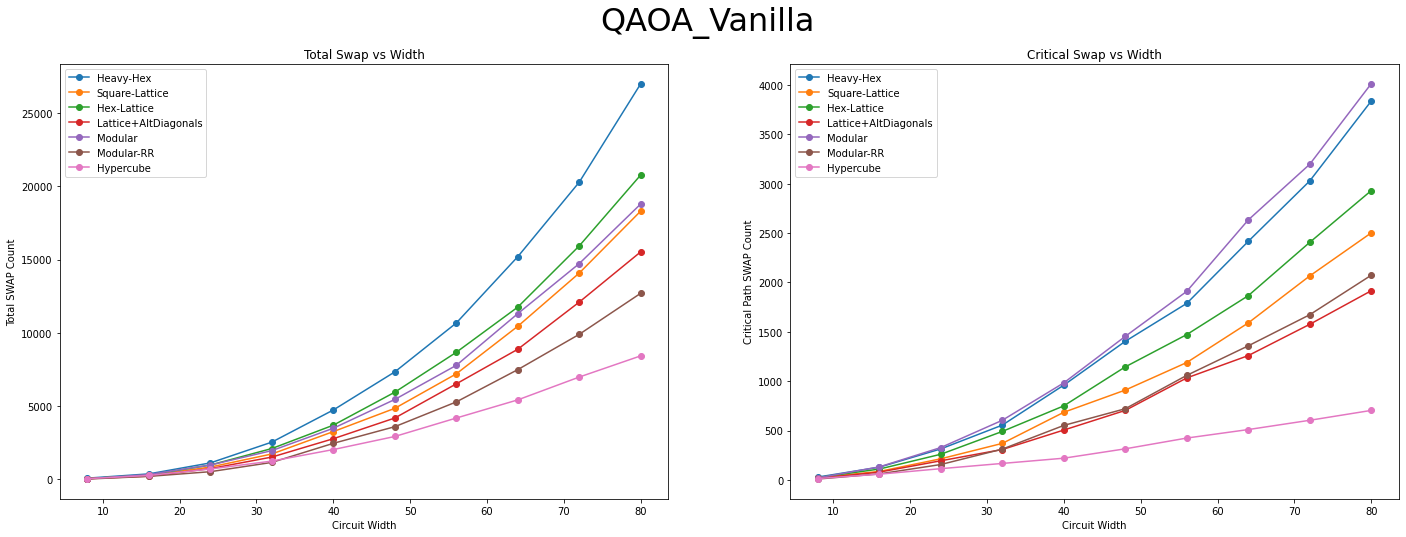

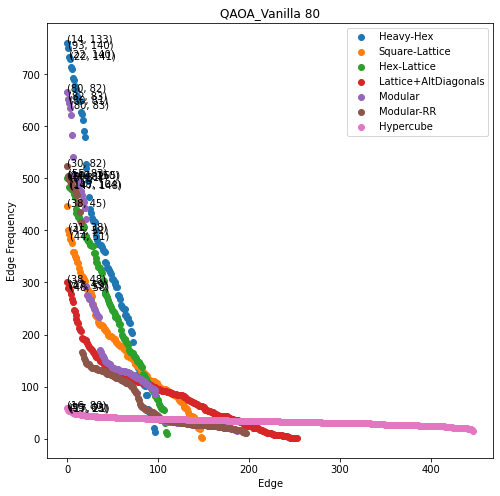

In [18]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

circuit_gen = circuits["QAOA_Vanilla"]
benchmark(
    backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True
)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output="mpl", reverse_bits=True)


Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


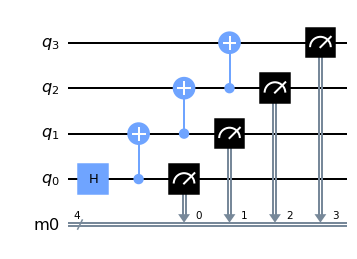

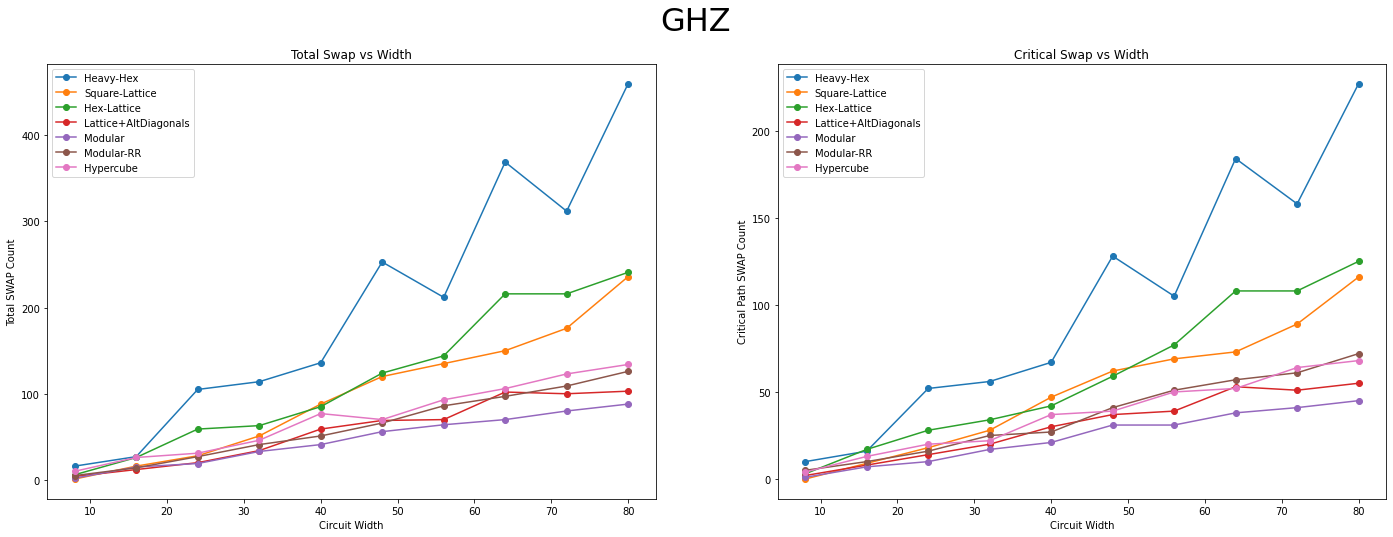

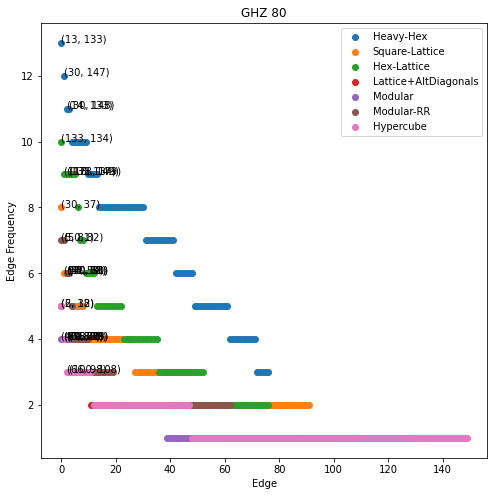

In [19]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

circuit_gen = circuits["GHZ"]
benchmark(
    backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True
)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output="mpl", reverse_bits=True)


Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


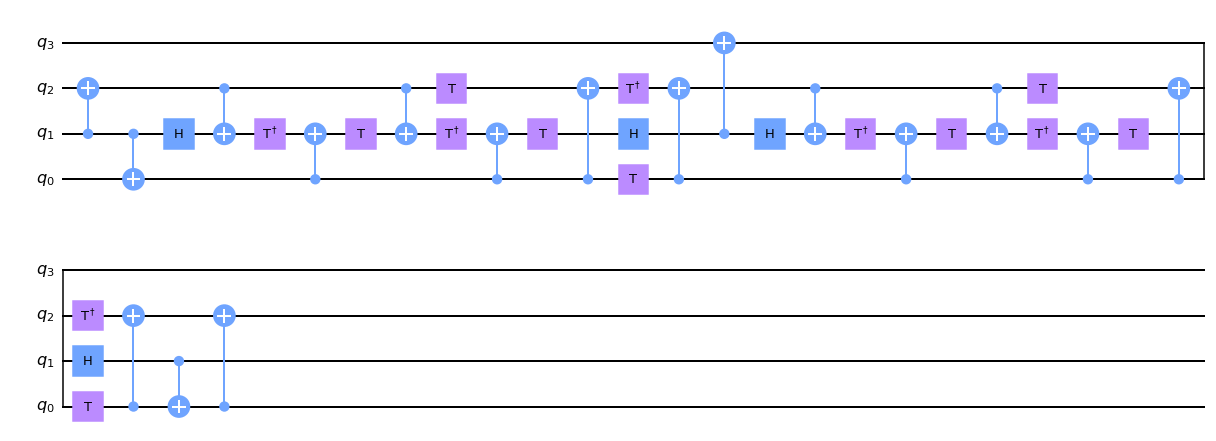

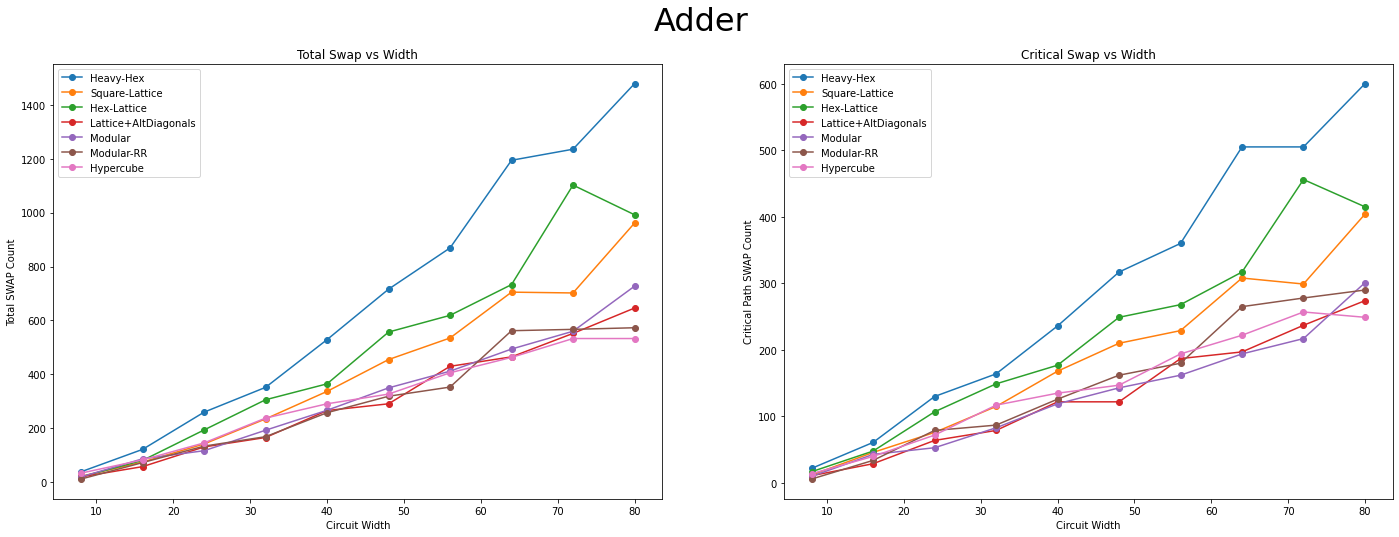

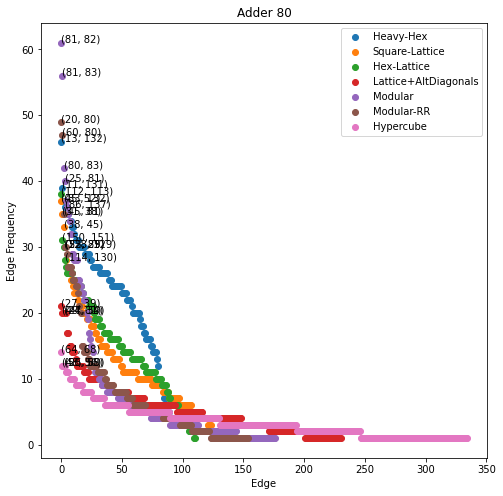

In [20]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

circuit_gen = circuits["Adder"]
benchmark(
    backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True
)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output="mpl", reverse_bits=True)


Text(0.5, 0.98, 'Topology Parameters as predictors for transpilation success')

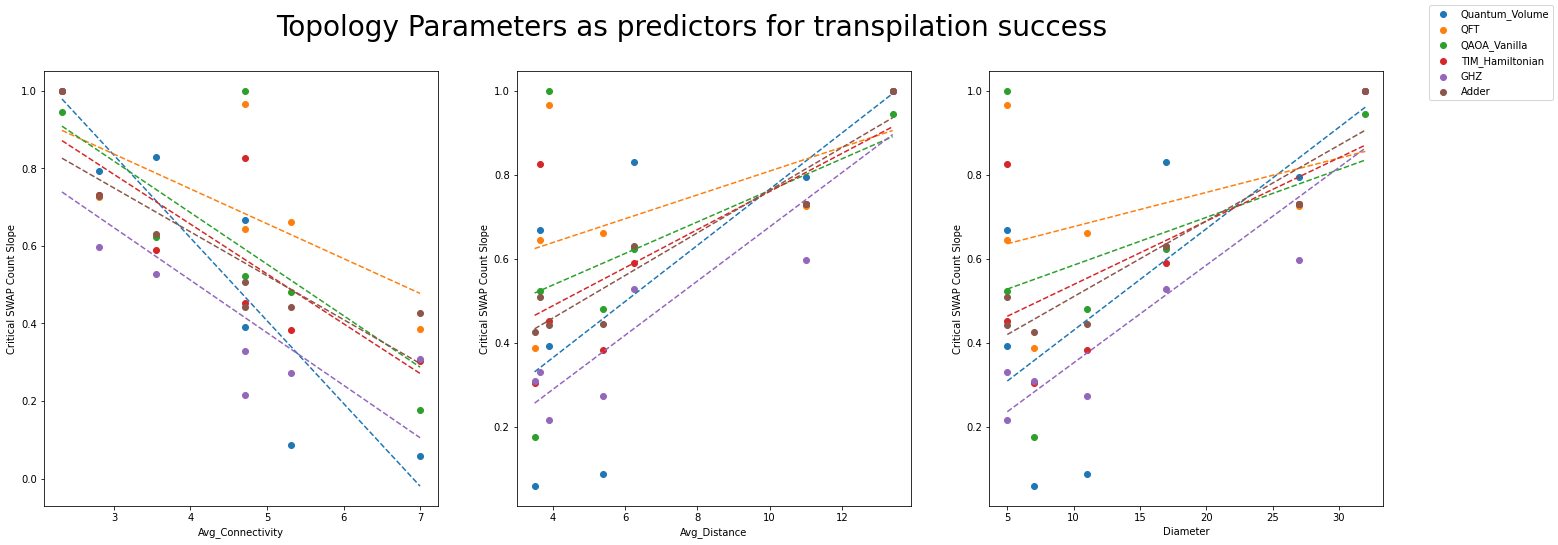

In [58]:
# try and do some data analysis
# requires backend_analysis_main.ipynb to be ran first
from matplotlib import pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

for circuit_label in circuits.keys():
    # for circuit_label in ["GHZ"]:
    slope_list = []
    backend_property1 = []
    backend_property2 = []
    backend_property3 = []
    for backend in topology_backends:
        x = backend.data[circuit_label]["gate_count_crit"].keys()
        x = [int(el) for el in list(x)]
        y = backend.data[circuit_label]["gate_count_crit"].values()
        x, y = zip(*zip(x, y))
        y = [el["swap"] if "swap" in el.keys() else 0 for el in y]
        x, y = zip(*sorted(zip(x, y)))
        from scipy.stats import linregress

        slope_list.append(linregress(x, y).slope)
        backend_property1.append(
            backend.data["Avg_Connectivity"]
        )  # Diameter, Avg_Distance, Avg_Connectivity
        backend_property2.append(backend.data["Avg_Distance"])
        backend_property3.append(backend.data["Diameter"])
        # backend_property3.append(backend.data["Avg_Connectivity"]/backend.data["Avg_Distance"])

    # normalize slopes?
    slope_list = [el / max(slope_list) for el in slope_list]

    import numpy as np

    ax1.scatter(backend_property1, slope_list, label=circuit_label)
    x = backend_property1
    y = slope_list
    ax1.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), "--")

    ax2.scatter(backend_property2, slope_list, label=circuit_label)
    x = backend_property2
    ax2.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), "--")

    ax3.scatter(backend_property3, slope_list, label=circuit_label)
    x = backend_property3
    ax3.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), "--")

ax1.set_xlabel("Avg_Connectivity")
ax2.set_xlabel("Avg_Distance")
ax3.set_xlabel("Diameter")
ax1.set_ylabel("Critical SWAP Count Slope")
ax2.set_ylabel("Critical SWAP Count Slope")
ax3.set_ylabel("Critical SWAP Count Slope")

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels)
# ax2.legend()

fig.suptitle("Topology Parameters as predictors for transpilation success", size=28)


TODO: above data needs to be averaged, using better metric than linregress?, need r^2 values on lines

In [22]:
# from backend_suite_v2 import topology_backends
# from circuit_suite import circuits
# circuit_gen = circuits["Multiplier"]
# # circuit_gen.circuit_lambda(8).draw(output='mpl')
# #benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
# plot(topology_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).draw(output='mpl', reverse_bits=True)


# Edge Contention Tests

In [23]:
# from backend_suite_v2 import dummy_backends
# from circuit_suite import circuits
# circuit_gen = circuits["QAOA_Vanilla"]
# benchmark(backends=dummy_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
# plot(dummy_backends, circuit_gen.label)
# edge_histogram(dummy_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)
